# Tutorial 1: Simulated Spatially Resolved Paired Multi-Omics Data

We  simulated a spatially resolved multi-omics dataset from mouse visual cortex STARmap spatial transcriptomics data, which consists of 1207 cells annotated by six layer labels:  L1, L2/3, L4, L5, L6, and HPC/CC. We generated two datasets (termed as “Omics-1” and “Omics-2” ) by shuffling cells in L4/L5 and L5/L6, respectively, and then added Gaussian noise to the expression values. We applied COSMOS to integrate the two datasets and evaluated its performance.

The raw data can be downloaded from: 
https://www.dropbox.com/sh/f7ebheru1lbz91s/AADm6D54GSEFXB1feRy6OSASa/visual_1020/20180505_BY3_1kgenes?dl=0&subfolder_nav_tracking=1

The processed data is available at: https://zenodo.org/records/13932144

In [53]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib
import matplotlib.pyplot as plt
from umap import UMAP
import sklearn
import seaborn as sns
# from COSMOS.cosmos import Cosmos
from COSMOS.cosmos_transformer_pe_version import Cosmos
from COSMOS.pyWNN import pyWNN 
import warnings
warnings.filterwarnings('ignore')
random_seed = 20

## Preparation of data

### Importing the spatially resolved transcriptomics data

In [54]:
# Importing mouse visual cortex STARMap data
df_data = pd.read_csv('./MVC_counts.csv',sep=",",header=0,na_filter=False,index_col=0) 
df_meta = pd.read_csv('./MVC_meta.csv',sep=",",header=0,na_filter=False,index_col=0) 
df_pixels = df_meta.iloc[:,2:4]
df_labels = list(df_meta.iloc[:,1])
adata = sc.AnnData(X = df_data)
adata.obs['LayerName'] = df_labels # Combining HPC and CC
adata.obs['LayerName_2'] = list(df_meta.iloc[:,4]) # Separating HPC and CC

# Spatial positions
adata.obsm['spatial'] = np.array(df_pixels)
adata.obs['x_pos'] = adata.obsm['spatial'][:,0]
adata.obs['y_pos'] = adata.obsm['spatial'][:,1]
label_type = ['L1','L2/3','L4','L5','L6','HPC/CC']

### Generating simulated spatially resolved paired multi-omics data

In [55]:
# Shuffling L4/L5 and L5/L6 of the original data, respectively.
index_all = [np.array([i for i in range(len(df_labels)) if df_labels[i] == label_type[0]])]
for k in range(1,len(label_type)):
    temp_idx = np.array([i for i in range(len(df_labels)) if df_labels[i] == label_type[k]])
    index_all.append(temp_idx)
index_int1 = np.array(list(index_all[2]) + list(index_all[3]))
index_int2 = np.array(list(index_all[4]) + list(index_all[3]))

# Adding Gaussian noise to each omics
adata1 = adata.copy()
np.random.seed(random_seed)
data_noise_1 = 1 + np.random.normal(0,0.05,adata.shape)
adata1.X[index_int1,:] = np.multiply(adata.X,data_noise_1)[np.random.permutation(index_int1),:]

adata2 = adata.copy()
np.random.seed(random_seed+1)
data_noise_2 = 1 + np.random.normal(0,0.05,adata.shape)
adata2.X[index_int2,:] = np.multiply(adata.X,data_noise_2)[np.random.permutation(index_int2),:]

## Applying COSMOS to integrate the two omics

In [56]:
# COSMOS integration
cosmos_comb = Cosmos(adata1=adata1,adata2=adata2)
cosmos_comb.preprocessing_data(n_neighbors = 10)
cosmos_comb.train(spatial_regularization_strength=0, z_dim=50, 
         lr=1e-3, wnn_epoch = 100, total_epoch=1000, max_patience_bef=10, max_patience_aft=30, min_stop=200, 
         random_seed=random_seed, gpu=0, regularization_acceleration=True, edge_subset_sz=1000000, num_heads=2, dropout=0.3, use_pe=False, pe_dim=0)

✓ Preprocessing complete:
  - Cells: 1207
  - Modality 1 features: 1020
  - Modality 2 features: 1020
  - Spatial neighbors: 10

COSMOS: Graph Transformer + Positional Encoding
Architecture:
  - Model: Graph Transformer
  - Attention heads: 2
  - Dropout: 0.3
  - Positional Encoding: ✗ Disabled
  - Output dimension: 50

Training:
  - Total epochs: 1000
  - WNN computation at epoch: 100
  - Learning rate: 0.001
  - Spatial regularization: 0
  - Device: cuda:0
  - Random seed: 20

Starting training...
Epoch 1/1000, Loss: 1.409143
Epoch 11/1000, Loss: 1.386387
Epoch 21/1000, Loss: 1.362648
Epoch 31/1000, Loss: 1.058754
Epoch 41/1000, Loss: 0.514441
Epoch 51/1000, Loss: 0.261502
Epoch 61/1000, Loss: 0.153297
Epoch 71/1000, Loss: 0.126742
Epoch 81/1000, Loss: 0.069373
Epoch 91/1000, Loss: 0.059535
Computing KNN distance matrices using default Scanpy implementation
Computing modality weights
Computing weighted distances for union of 200 nearest neighbors between modalities
0 out of 1207 0.01

array([[ 0.17624727  , -0.023988264 ,  0.1389825   , ..., -0.10367004  ,
         0.03994323  ,  0.2480909   ],
       [ 0.114861876 , -0.057154108 ,  0.033936534 , ..., -0.10773262  ,
         0.0020426915,  0.16307728  ],
       [ 0.06883942  , -0.055132147 ,  0.11859296  , ..., -0.07883645  ,
         0.06902563  ,  0.14907166  ],
       ...,
       [ 0.08840779  , -0.06397013  ,  0.09456144  , ..., -0.093338296 ,
         0.034625847 ,  0.17382707  ],
       [ 0.098544    , -0.052836657 ,  0.13331254  , ..., -0.09906461  ,
         0.15459442  ,  0.06625961  ],
       [ 0.09400856  , -0.10938547  ,  0.09612808  , ..., -0.10367738  ,
        -0.0026512155,  0.07135252  ]], shape=(1207, 50), dtype=float32)

### Domain segmentation by COSMOS integration

In [57]:
def screen_resolution(df_embedding, labels, res_s = 0.1, res_e = 1.0, step = 0.05, methods = 'leiden'):
    max_ari = 0
    opt_res = 0
    rec_ari = []
    rec_res = []
    rec_cluster_num = []
    for res in np.arange(res_s,res_e,step):
        embedding_adata = sc.AnnData(df_embedding)
        sc.pp.neighbors(embedding_adata, n_neighbors=50, use_rep='X')
        if methods == 'leiden':
            sc.tl.leiden(embedding_adata, resolution=float(res))
            clusters = list(embedding_adata.obs["leiden"])
        else:
            sc.tl.louvain(embedding_adata, resolution=float(res))
            clusters = list(embedding_adata.obs["louvain"])
        ARI_score = sklearn.metrics.adjusted_rand_score(labels, clusters)
        ARI_score = round(ARI_score, 2)
        cluster_num = len(np.unique(clusters))
        print('res = ' + str(round(res, 2)) + ', ARI = ' + str(ARI_score) + ', Cluster# = ' + str(cluster_num))
        rec_ari.append(ARI_score)
        rec_res.append(res)
        rec_cluster_num.append(cluster_num)
    print('Maximal ARI = ' + str(max(rec_ari)) + ' with res = ' + str(round(rec_res[np.argmax(rec_ari)],2)))
    return rec_ari, rec_res, rec_cluster_num



res = 0.2, ARI = 0.33, Cluster# = 3
res = 0.21, ARI = 0.33, Cluster# = 3
res = 0.22, ARI = 0.33, Cluster# = 3
res = 0.23, ARI = 0.33, Cluster# = 3
res = 0.24, ARI = 0.33, Cluster# = 3
res = 0.25, ARI = 0.33, Cluster# = 3
res = 0.26, ARI = 0.33, Cluster# = 3
res = 0.27, ARI = 0.33, Cluster# = 3
res = 0.28, ARI = 0.32, Cluster# = 3
res = 0.29, ARI = 0.33, Cluster# = 3
res = 0.3, ARI = 0.33, Cluster# = 3
res = 0.31, ARI = 0.33, Cluster# = 3
res = 0.32, ARI = 0.33, Cluster# = 3
res = 0.33, ARI = 0.33, Cluster# = 3
res = 0.34, ARI = 0.33, Cluster# = 3
res = 0.35, ARI = 0.33, Cluster# = 3
res = 0.36, ARI = 0.33, Cluster# = 3
res = 0.37, ARI = 0.33, Cluster# = 3
res = 0.38, ARI = 0.3, Cluster# = 4
res = 0.39, ARI = 0.3, Cluster# = 4
res = 0.4, ARI = 0.3, Cluster# = 4
res = 0.41, ARI = 0.3, Cluster# = 4
res = 0.42, ARI = 0.3, Cluster# = 4
res = 0.43, ARI = 0.33, Cluster# = 3
res = 0.44, ARI = 0.3, Cluster# = 4
res = 0.45, ARI = 0.3, Cluster# = 4
res = 0.46, ARI = 0.3, Cluster# = 4
res = 0.47, 

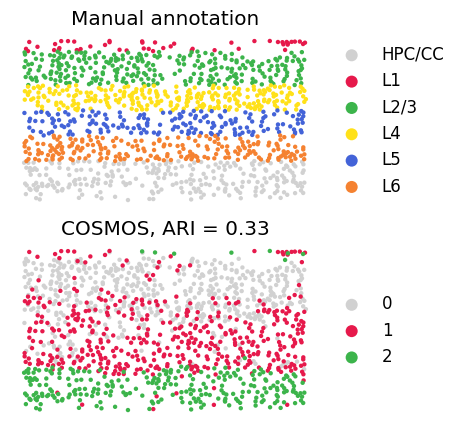

In [58]:
# Obtaining the optimal domain segmentation

adata_new = adata1.copy()
label_annotations = list(adata.obs['LayerName'])

alpha = 0
res_s = 0.2
res_e = 0.5
step = 0.01
methods = 'leiden'
df_embedding = pd.DataFrame(cosmos_comb.embedding)
rec_ari, rec_res, rec_cluster_num = screen_resolution(df_embedding, label_annotations, res_s = res_s, res_e = res_e, step = step, methods = methods)

opt_ari_cosmos = max(rec_ari)
opt_res_cosmos = rec_res[np.argmax(rec_ari)]
embedding_adata = sc.AnnData(df_embedding)
sc.pp.neighbors(embedding_adata, n_neighbors=50, use_rep='X')
sc.tl.leiden(embedding_adata, resolution=float(opt_res_cosmos))
opt_clusters_cosmos = list(embedding_adata.obs["leiden"])
adata_new.obs['Cluster_cosmos'] = opt_clusters_cosmos
adata_new.obs["Cluster_cosmos"]=adata_new.obs["Cluster_cosmos"].astype('category')

matplotlib.rcParams['font.size'] = 12.0
fig, axes = plt.subplots(2, 1, figsize=(4,5))
sz = 40
plot_color=['#D1D1D1','#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', \
            '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#ffd8b1', '#800000', '#aaffc3', '#808000', '#000075', '#000000', '#808080', '#ffffff', '#fffac8']

domains="LayerName"
num_celltype=len(adata_new.obs[domains].unique())
adata_new.uns[domains+"_colors"]=list(plot_color[:num_celltype])
titles = 'Manual annotation' 
ax=sc.pl.scatter(adata_new,alpha=1,x="x_pos",y="y_pos",color=domains,title=titles ,color_map=plot_color,show=False,size=sz,ax = axes[0])
ax.axis('off')

domains="Cluster_cosmos"
num_celltype=len(adata_new.obs[domains].unique())
adata_new.uns[domains+"_colors"]=list(plot_color[:num_celltype])
titles = 'COSMOS, ARI = ' + str(opt_ari_cosmos)
ax=sc.pl.scatter(adata_new,alpha=1,x="x_pos",y="y_pos",color=domains,title=titles ,color_map=plot_color,show=False,size=sz,ax = axes[1])
ax.axis('off')
plt.show()

### UMAP visualization of COSMOS integration

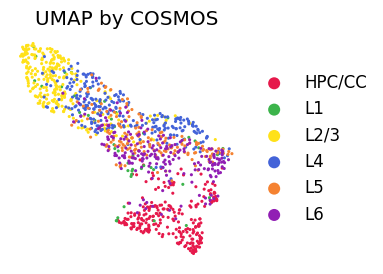

In [59]:
umap_2d = UMAP(n_components=2, init='random', random_state=random_seed, min_dist = 0.3,n_neighbors=30)
umap_pos = umap_2d.fit_transform(df_embedding)
adata_new.obs['cosmos_umap_pos_x'] = umap_pos[:,0]
adata_new.obs['cosmos_umap_pos_y'] = umap_pos[:,1]

matplotlib.rcParams['font.size'] = 12.0
sz = 20
fig, axes = plt.subplots(1, 1, figsize=(3,3))

plot_color=['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', \
            '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#ffd8b1', '#800000', '#aaffc3', '#808000', '#000075', '#000000', '#808080', '#ffffff', '#fffac8']

domains="LayerName"
num_celltype=len(adata_new.obs[domains].unique())
adata_new.uns[domains+"_colors"]=list(plot_color[:num_celltype])
titles = 'UMAP by COSMOS' 
ax=sc.pl.scatter(adata_new,alpha=1,x="cosmos_umap_pos_x",y="cosmos_umap_pos_y",color=domains,title=titles ,color_map=plot_color,show=False,size=sz,ax = axes)
ax.axis('off')
plt.show()


### Pseudo-spatiotemporal map (pSM) from COSMOS integration

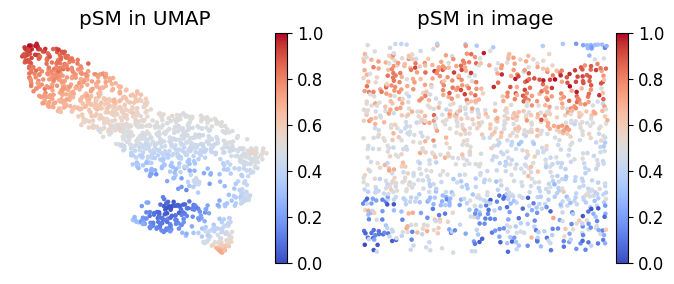

In [60]:
sc.pp.neighbors(embedding_adata, n_neighbors=20, use_rep='X')
# Setting the root to be the first cell in 'HPC' cells
embedding_adata.uns['iroot'] = np.flatnonzero(adata.obs['LayerName_2'] == 'HPC')[0]
# Diffusion map
sc.tl.diffmap(embedding_adata)
# Diffusion pseudotime
sc.tl.dpt(embedding_adata)
pSM_values = embedding_adata.obs['dpt_pseudotime'].to_numpy()

matplotlib.rcParams['font.size'] = 12.0
sz = 20
fig, axes = plt.subplots(1, 2, figsize=(7,3))

x = np.array(adata_new.obs['cosmos_umap_pos_x'])
y = np.array(adata_new.obs['cosmos_umap_pos_y'])
ax_temp = axes[0]
im = ax_temp.scatter(x, y, s=sz, c=pSM_values, marker='.', cmap='coolwarm',alpha = 1)
ax_temp.axis('off')
ax_temp.set_title('pSM in UMAP')
fig.colorbar(im, ax = ax_temp,orientation="vertical", pad=-0.01)

x = np.array(adata_new.obs['x_pos'])
y = np.array(adata_new.obs['y_pos'])
ax_temp = axes[1]
im = ax_temp.scatter(x, y, s=sz, c=pSM_values, marker='.', cmap='coolwarm',alpha = 1)
ax_temp.axis('off')
ax_temp.set_title('pSM in image')
fig.colorbar(im, ax = ax_temp,orientation="vertical", pad=-0.01)


plt.tight_layout()
plt.show()

### Showing modality weights of two omics in COSMOS integration

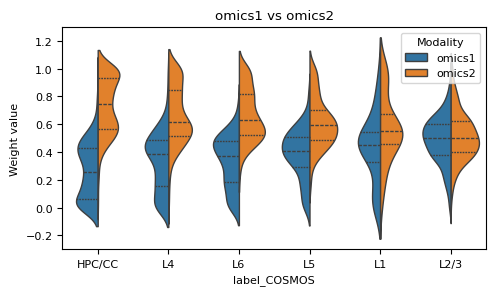

In [61]:
def plot_weight_value(alpha, label, modality1='omics1', modality2='omics2',order = None):
    df = pd.DataFrame(columns=[modality1, modality2, 'label'])  
    df[modality1], df[modality2] = alpha[:, 0], alpha[:, 1]
    df['label'] = label
    df = df.set_index('label').stack().reset_index()
    df.columns = ['label_COSMOS', 'Modality', 'Weight value']
    matplotlib.rcParams['font.size'] = 8.0
    fig, axes = plt.subplots(1, 1, figsize=(5,3))
    ax = sns.violinplot(data=df, x='label_COSMOS', y='Weight value', hue="Modality",
                split=True, inner="quart", linewidth=1, orient = 'v', order=order)
    ax.set_title(modality1 + ' vs ' + modality2) 
    plt.tight_layout(w_pad=0.05)

weights = cosmos_comb.weights
df_wghts = pd.DataFrame(weights,columns = ['w1','w2'])
weights = np.array(df_wghts)
for k in range(1,len(label_type)):
    wghts_mean = np.mean(weights[index_all[0],:],0)
for k in range(1,len(label_type)):
    wghts_mean_temp = np.mean(weights[index_all[k],:],0)
    wghts_mean = np.vstack([wghts_mean, wghts_mean_temp])
df_wghts_mean = pd.DataFrame(wghts_mean,columns = ['w1','w2'],index = label_type)
df_sort_mean = df_wghts_mean.sort_values(by=['w1'])
plot_weight_value(np.array(df_wghts), np.array(adata.obs['LayerName']), order = list(df_sort_mean.index))
plt.show()